### Оценка потенциального экономического эффекта от внедрения полученного решения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection, linear_model, preprocessing, ensemble, metrics, svm, manifold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
import xgboost as xgb
from sklearn.model_selection import learning_curve
import lightgbm as lgb
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler

In [3]:
data = pd.read_csv('Train_full.csv', sep =',')
data.head(10)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,...,6Uh67Lk,LM8l689qOp,NaN,NaN,453m,02N6s8f,F2FyR07IdsN7I,NaN,NaN,-1
6,NaN,NaN,NaN,NaN,NaN,889.0,0.0,NaN,NaN,NaN,...,d0BOtEt,LM8l689qOp,NaN,NaN,3Cy4,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
7,NaN,NaN,NaN,NaN,NaN,161.0,0.0,NaN,NaN,NaN,...,AmO2pc5,LM8l689qOp,NaN,NaN,5Acm,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
8,NaN,NaN,NaN,NaN,NaN,420.0,0.0,NaN,NaN,NaN,...,APgu8Zv,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
9,NaN,NaN,NaN,NaN,NaN,1155.0,0.0,NaN,NaN,NaN,...,JaZwBif,LM8l689qOp,NaN,NaN,uWr3,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


In [4]:
def labelEncoder(data):
    data = data.fillna(0)
    le = preprocessing.LabelEncoder()
    for m in range(190,230):
        le.fit(data.iloc[:,m].astype(str))
        data.iloc[:,m] = le.transform(data.iloc[:,m].astype(str))       
    return data
def dropUninformative(data):
    df = pd.DataFrame([])
    for i in range(data.shape[1]):
        if len(np.unique(data.iloc[:,i]))>1:
            df["Var"+str(i)] = data.iloc[:,i]
    return df

In [5]:
def economic_model(y_true, predicted, top, incomeFor1, costFor1, randomChance):
    df_clients = pd.DataFrame([])
    df_clients['predict'] = predicted
    df_clients['y_true'] = y_true
    df_clients['profit'] = 0
    np.random.seed(27)
    rands = pd.DataFrame(data = np.random.random(len(predicted)), columns=['random'])
    df_clients.sort_values('predict', inplace = True, ascending=False)
    threshold = df_clients.iloc[int(len(df_clients)*top)-1, 0]
    profit = 0
    
    df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == 1)].index] = 0
    df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == -1)].index] = incomeFor1 
    df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == 1)][(rands['random']>randomChance)].index]= 0-costFor1
    df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == 1)][(rands['random']<randomChance)].index]= incomeFor1-costFor1 
    df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == -1)].index] = incomeFor1-costFor1
    
    profit = sum(df_clients['profit'])
    
    statistic = stats(df_clients, top, profit, incomeFor1, costFor1, 0.2, randomChance)
    return profit, df_clients, statistic

In [6]:
def plot_income(y_true, predicted, incomeFor1, costFor1, randomChance):
    tops = np.linspace(0.005,1., num = 200)
    incomes = []
    statistic = pd.DataFrame([])
    for top in tops:
        incomes.append(economic_model(y_true, predicted, top, incomeFor1, costFor1, randomChance)[0])
        statistic=statistic.append(economic_model(y_true, predicted, top, incomeFor1, costFor1, randomChance)[2], ignore_index=True)
    plt.figure(figsize=(20,10))
    plt.title(u"график зависимости полученной прибыли от топа прогнозируемых клиентов после проведения кампании по удержанию")
    plt.xlabel("Top")
    plt.ylabel("Profit")
    plt.plot(tops, incomes, color="g", label=u"прибыль с учетом прогноза оттока")
    plt.plot(tops[0], incomes[0], 'ro', label = u'соответствует значению без удержания клиентов')
    plt.plot(tops[-1], incomes[-1], 'bo', label = u'соответствует значению после опроса всех клиентов')
    df = pd.DataFrame([])
    df['Profit'] = incomes
    df['Top'] = tops
    plt.legend(loc="best")
    return df, statistic

In [22]:
def plot_stats(df):
    plt.figure(figsize=(20,10))
    plt.title(title)
    plt.xlabel("Top")
    plt.ylabel("Profit")
    plt.plot(df.iloc[:,0], df.iloc[:,1], '-.', color="r", label=u"прибыль с 30% оттока")
    plt.plot(df.iloc[:,0], df.iloc[:,2], '--',color="m", label=u"прибыль с учетом обзвона всех клиентов")
    plt.plot(df.iloc[:,0], df.iloc[:,3],color="g", label=u"прибыль с учетом прогноза оттока")
    plt.plot(df.iloc[:,0], df.iloc[:,8],color="b", label=u"прибыль в будущем(после прогноза и затрат)")
    plt.title(u"график зависимости полученной прибыли от топа прогнозируемых клиентов после проведения кампании по удержанию")
    plt.legend(loc="best")

In [13]:
def stats(df, top, profit, incomeFor1, costFor1, churn, chance):
    temp = pd.DataFrame([[top,
                        len(df)*(1-churn)*incomeFor1,
                        len(df)*1.*(incomeFor1-costFor1) - len(df)*churn*(incomeFor1)*(1-chance),
                        profit,
                        len(df),
                        int(len(df)*(1-churn)),
                        len(df[df['profit']>0]),
                        len(df)*incomeFor1*0.8,
                        len(df[df['profit']>0])*incomeFor1]],
                        columns=['top of predicted clients',
                                'profit without anything',
                                'profit with all called clients',
                                'profit with predicted clients',
                                'number of clients before predict',
                                'number of clients after no predict',
                                'number of clients after predict',
                                'profit in next time(no predict, next month with action)',
                                'profit in next time(predict, next month with action)'])
    return temp

### Постановка задачи: в одном банке приоформлении кредитной карты действует акция: при оформлении карты действует акция: обслуживание - 0 р. в течение первого года. Будем прогнозировать пользователей, склонных к оттоку после окончания действия акции. 
### исходные данные:
#### Процент конверсии пользователей - 25%;
#### цена тарифного плана после окончания скидки 3500р в год ();
#### затраты денег в среднем на удержание одного пользователя + затраты на работу сотрудников на одного клиента;
#### предлагаем 30% скидку пользователям, склонных к оттоку;
#### Процент согласившихся пользователей, после мероприятий по удержанию 60%. Для нужного нам процента конверсии обрезаем тестовую выборку в соотношении 1:4(отток/не отток); расходы считаем как сумма скидки для удерживаемого клиента + затрата на звонок. В среднем у сотрудника колл-центра уходит 15 минут на разговор с клиентом, зарплата у сотрудника 30000р., т.е. затрата на звонок = зарплата/рабочие_дни/рабочие_часы/минуты*время_звонка -> 37.5 р.

In [7]:
# подготавливаем выборку
x_data = data.iloc[:,:230]
y_data = data.iloc[:,230:]
x_data = labelEncoder(x_data)
x_data = dropUninformative(x_data)
x_data.head(10)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 28)
x_test.head(10)
#x_test['labels'] = y_test
os =  RandomUnderSampler(sampling_strategy=0.25)
x_test, y_test = os.fit_resample(x_test, y_test)
x_test = pd.DataFrame(x_test, columns = x_data.columns)
y_test = pd.DataFrame(y_test, columns = ['labels'])
#x_test = labelEncoder(x_test)
#x_test = dropUninformative(x_test)
#x_test.head(10)
x_test.shape


(3770, 212)

In [8]:
x_data.head()

,Var0,Var1,Var2,Var3,Var4,Var5,Var6,Var8,Var9,Var10,...,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228
0,0.0,0.0,0.0,0.0,0.0,3052.0,0.0,0.0,0.0,0.0,...,2855,0,3696,1,0,0,14,0,29,0
1,0.0,0.0,0.0,0.0,0.0,1813.0,7.0,0.0,0.0,0.0,...,2864,4,347,1,0,1,22,2,2,2
2,0.0,0.0,0.0,0.0,0.0,1953.0,7.0,0.0,0.0,0.0,...,328,6,2498,1,0,0,7,3,25,2
3,0.0,0.0,0.0,0.0,0.0,1533.0,7.0,0.0,0.0,0.0,...,3834,4,2602,1,0,0,22,2,8,0
4,0.0,0.0,0.0,0.0,0.0,686.0,7.0,0.0,0.0,0.0,...,1653,4,1375,1,0,0,12,2,8,0


In [9]:
print (float(pd.value_counts(y_train['labels'])[-1])/len(y_train))
print (float(pd.value_counts(y_train['labels'])[1])/len(y_train))
print (float(pd.value_counts(y_test['labels'])[-1])/len(y_test))
print (float(pd.value_counts(y_test['labels'])[1])/len(y_test))

0.9259333333333334
0.07406666666666667
0.8
0.2


In [10]:
# обучение с параметрами прошлой недели
gbm = lgb.LGBMClassifier(colsample_bytree= 1.0,
                            max_depth= 2,
                            min_child_weight= 1,
                            n_estimators= 170,
                            reg_alpha= 0.4,
                            reg_lambda= 1.0,
                            subsample= 1.0)
gbm.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LGBMClassifier(max_depth=2, min_child_weight=1, n_estimators=170, reg_alpha=0.4,
               reg_lambda=1.0)

<ipython-input-5-35d85fb89029>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == 1)].index] = 0
<ipython-input-5-35d85fb89029>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == -1)].index] = incomeFor1
<ipython-input-5-35d85fb89029>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == 1)][(rands['random']>randomChance)].index]= 0-costFor1
<ipython-input-5-35d85fb89029>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == 1)][(rands['random']<randomChance)].index]= incomeFor1-costFor1
<ipyt

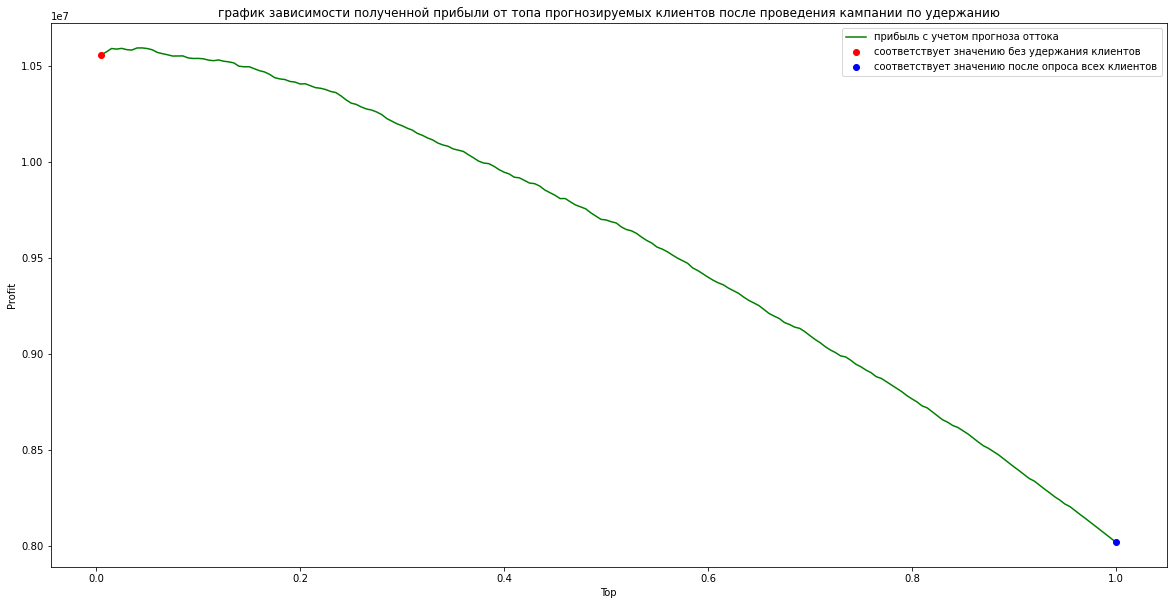

In [14]:
predicted = gbm.predict_proba(x_test.iloc[:,:212])[:,1]
incomeFor1 = 3500.
costFor1 = 37.5 + 0.30*incomeFor1
randomChance = 0.60
statistic = plot_income(y_test.values, predicted, incomeFor1, costFor1, randomChance)[1]

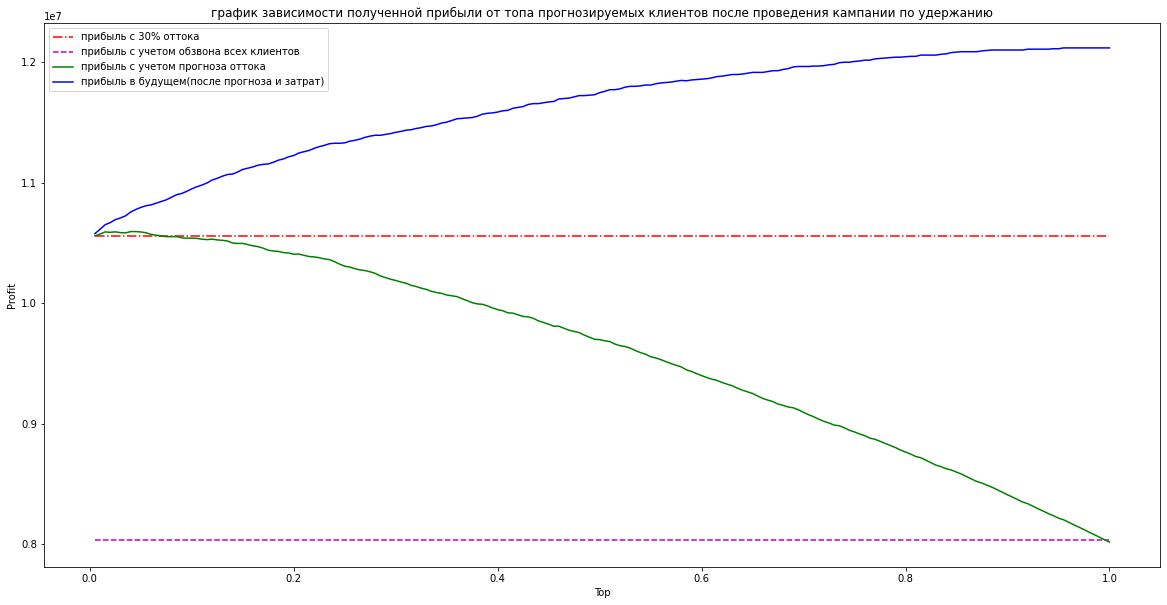

In [23]:
plot_stats(statistic)

#### 2. Топ пользователей, склонных к оттоку согласно модели, которых оптимально выбрать для проведения кампании по удержанию - примерно 6%. В этом случае экономический эффект был бы наибольшим.
#### 3. Попробую "поиграть с параметрами". Изменю стоимость удержания и вероятность, с которой пользователь принимает предложение клиент.
##### Шанс, с которым новый абонент согласится на услугу - 60%
##### Затраты на нового абонента - 25 р.(набрать на аутсорс сотрудников в регионах, студентов на лето).
##### Всем новым абонентам предлагаем скидку в 50% (1750 р.)

<ipython-input-5-35d85fb89029>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == 1)].index] = 0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-5-35d85fb89029>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == -1)].index] = incomeFor1
<ipython-input-5-35d85fb89029>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_client

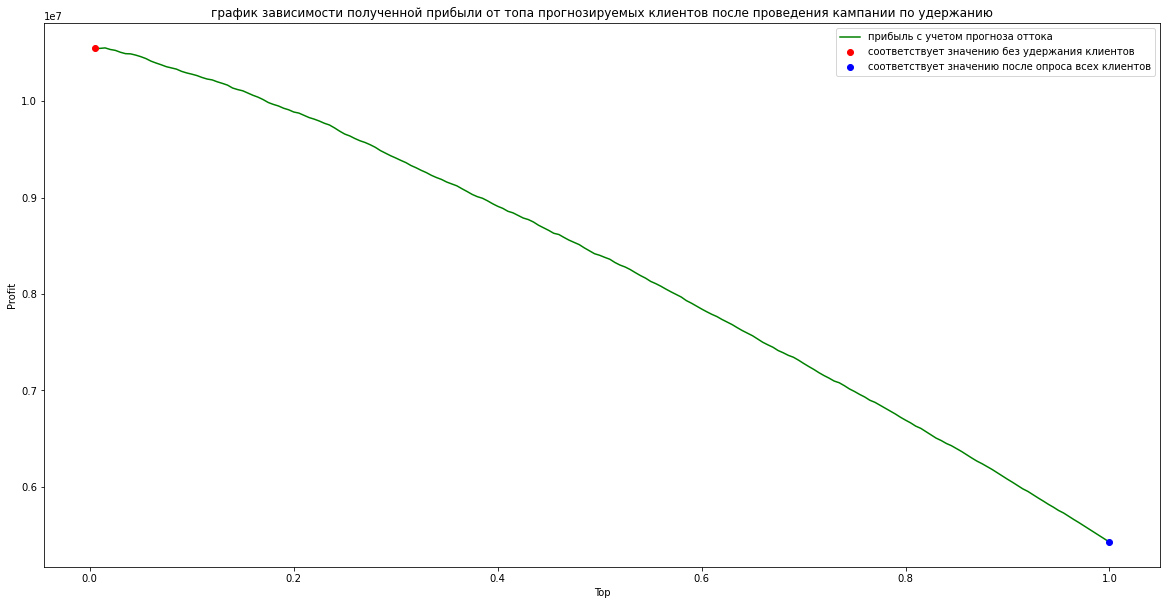

In [33]:
predicted = gbm.predict_proba(x_test.iloc[:,:212])[:,1]
incomeFor1 = 3500.
costFor1 = 25. + 0.50*incomeFor1
randomChance = 0.60
statistic = plot_income(y_test.values, predicted, incomeFor1, costFor1, randomChance)[1]

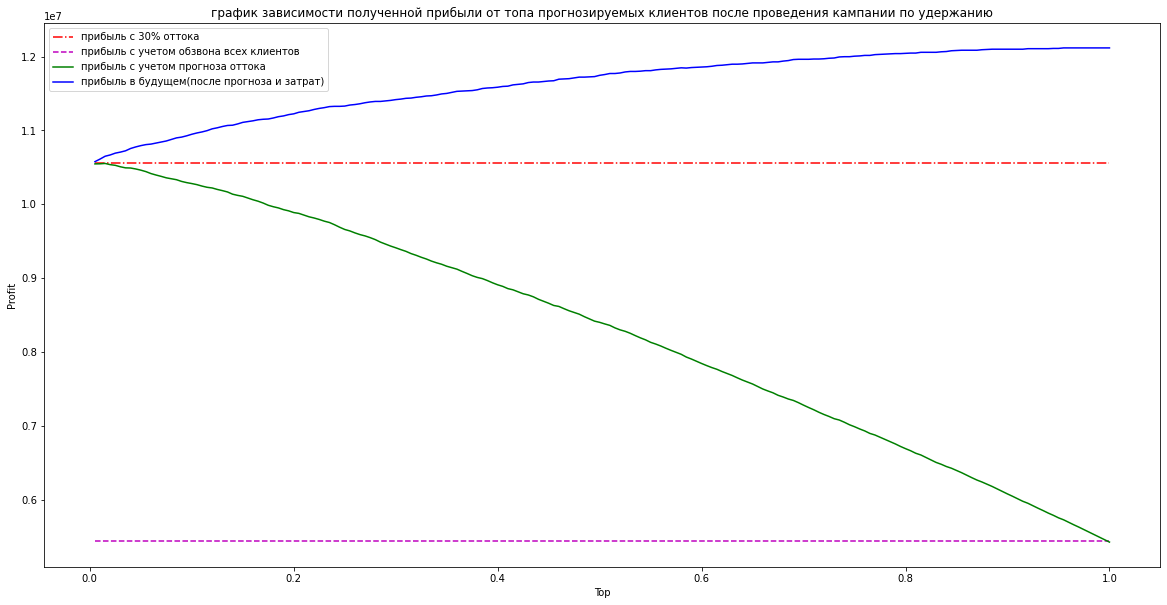

In [34]:
plot_stats(statistic)

Удержание пользователей не покрывает увеличивающиеся затраты на выделенную скидку, даже снижение затрат на зарплаты не помогает.

##### Шанс, с которым новый абонент согласится на услугу - 75%
##### Затраты на нового абонента - 37.5 р.
##### Всем новым абонентам предлагаем скидку в 30%

<ipython-input-5-35d85fb89029>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == 1)].index] = 0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-5-35d85fb89029>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == -1)].index] = incomeFor1
<ipython-input-5-35d85fb89029>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_client

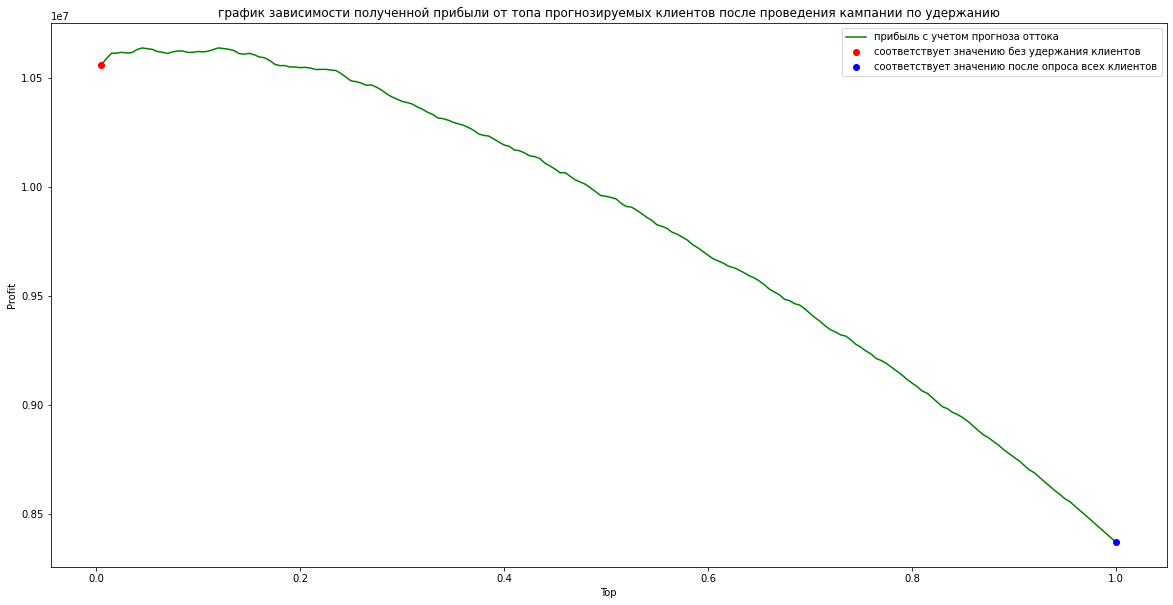

In [35]:
predicted = gbm.predict_proba(x_test.iloc[:,:212])[:,1]
incomeFor1 = 3500.
costFor1 = 37.5 + 0.30*incomeFor1
randomChance = 0.75
statistic = plot_income(y_test.values, predicted, incomeFor1, costFor1, randomChance)[1]

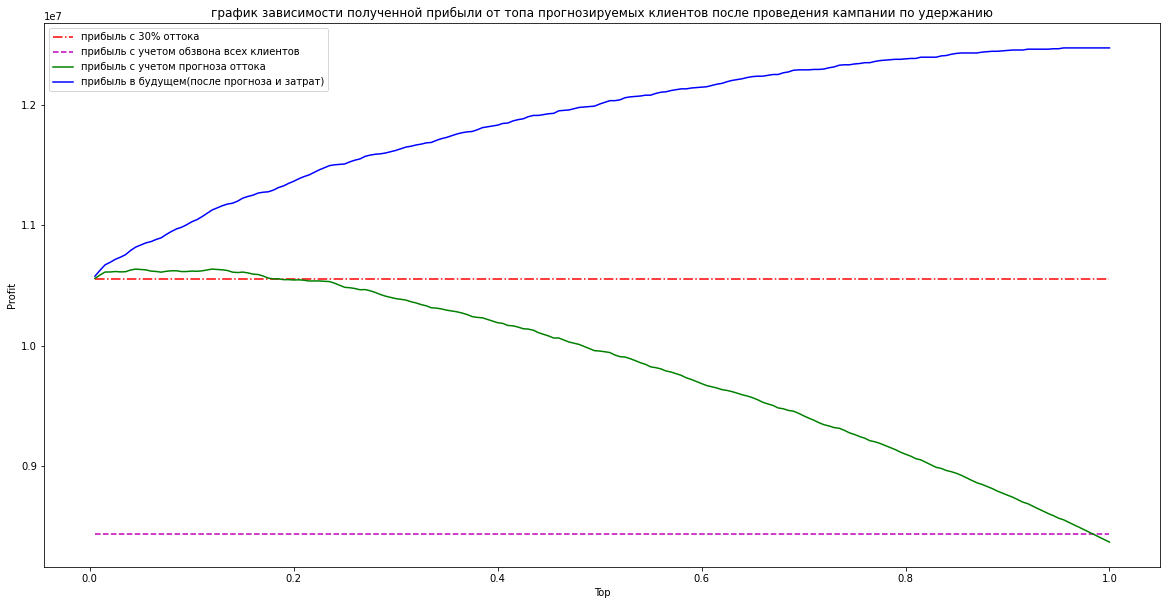

In [36]:
plot_stats(statistic)

При увеличении вероятности шанса, что клиент останется, топ становится равен 16-17%. Это было бы чудесно...

#### 4. Применение модели становится неоправданным в случае, когда затраты на удержание становятся большими настолько, что не "перебивают" удержание. Так было на предыдущем шаге, например. Вот ещё вариант:

##### Шанс, с которым новый абонент согласится на услугу - 60%
##### Затраты на нового абонента - 37.5 р.
##### Всем новым абонентам предлагаем скидку в 40% (2100 р.)

<ipython-input-5-35d85fb89029>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == 1)].index] = 0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-5-35d85fb89029>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == -1)].index] = incomeFor1
<ipython-input-5-35d85fb89029>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_client

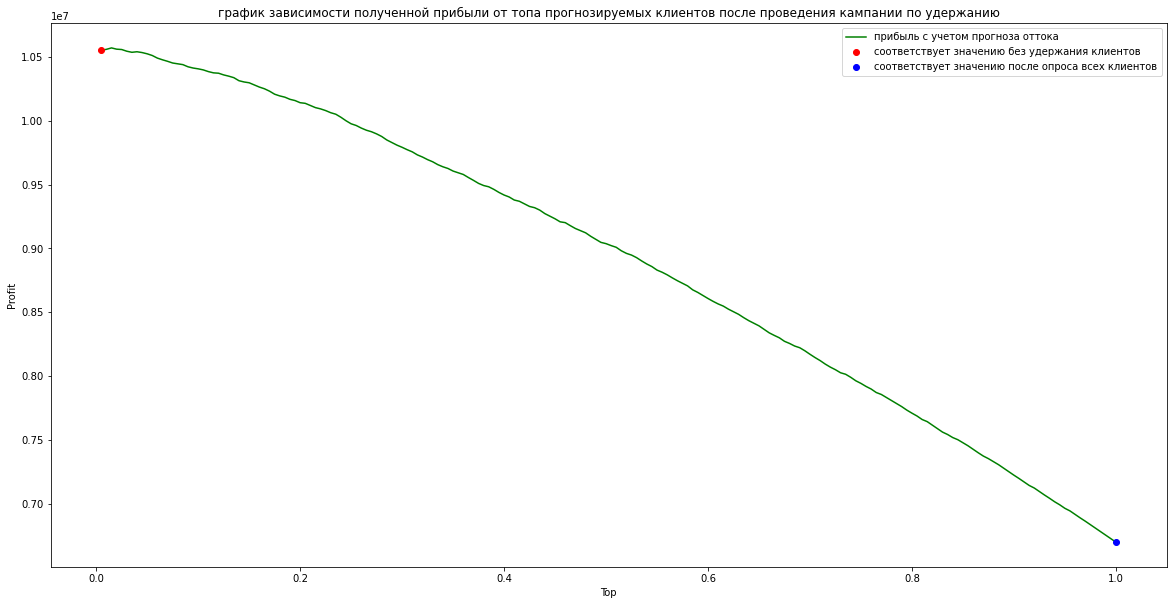

In [37]:
predicted = gbm.predict_proba(x_test.iloc[:,:212])[:,1]
incomeFor1 = 3500.
costFor1 = 37.5 + 0.40*incomeFor1
randomChance = 0.60
statistic = plot_income(y_test.values, predicted, incomeFor1, costFor1, randomChance)[1]

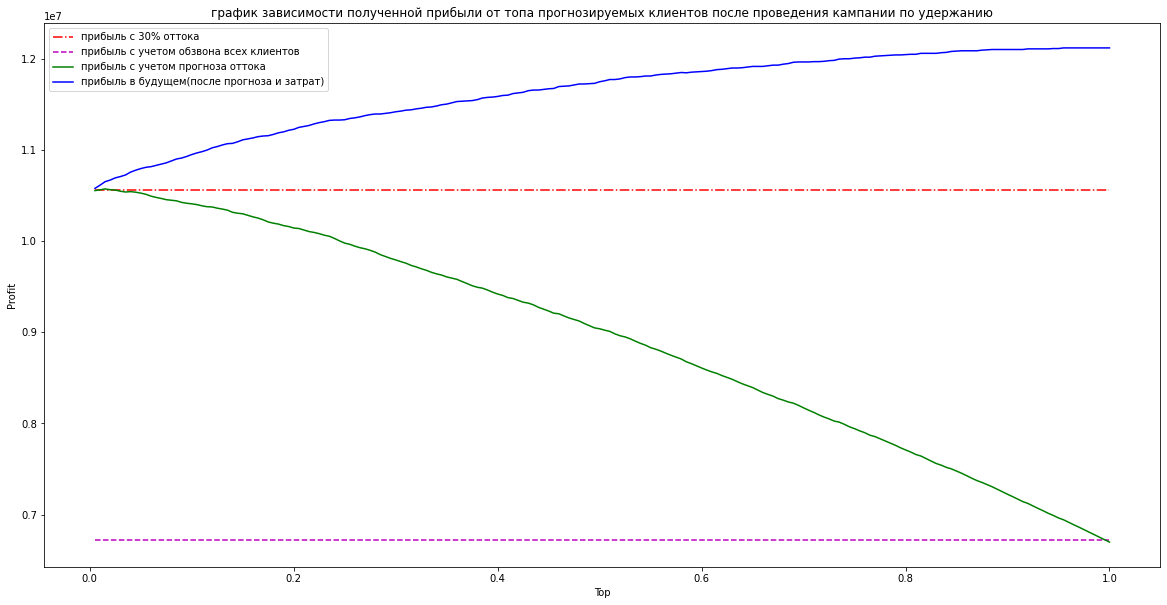

In [38]:
plot_stats(statistic)

#### 5. при увеличении качества модели на 1-3% экономический эффект будет малозаметен. Для увеличения экономического эффекта нужно что-то придумать для того, чтобы убрать выбросы из датасета.

#### 6. Экономически оправданным вложение средств в улучшение качества модели будет только в том случае, когда сам датасет будет избавлен он малоинформативных и/или компрометирующих параметров (выбросы, т.н. ошибкипервого/второго рода). Нужно понять, так ли сильно увеличится прибыль, окупит ли она ещё и затраты на увеличение качества...